In [96]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import pandas as pd

from icecream import ic
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers, losses
# from tensorflow.keras import lossesf
from tensorflow.keras.models import Model

from Data.Data_Loader import Data_Loader
from Model.simple_model import Pretrain_AutoEncoder
from Model.simple_model import DeepSVDD

MODEL_SAVE_DIR_PATH = os.path.abspath('pretrain_weight')

class CustomCallback(keras.callbacks.Callback):
    # def on_epoch_begin(self, epoch, logs=None):
    #     keys = list(logs.keys())
    #     print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print(f"this is test case{epoch}")


class Train:
    def __init__(self, config: dict, latent_dim, input_dim):
        self.config = config
        self.pretrain_ae = Pretrain_AutoEncoder(latent_dim=latent_dim, input_dim=input_dim)
        self.svdd = DeepSVDD(latent_dim=latent_dim, input_dim=input_dim)
        self.value = {'c': config['c'],
                      'R': config['R'],
                      'nu': config['nu']}
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.dist_op = 0.0
        self.data_loader = Data_Loader(self.config)
        self.check()
        self.dist = 0.0

    # weight 저장 폴더 생성
    def check(self):
        if not os.path.exists('pretrain_weight'):
            os.mkdir('pretrain_weight')

    def pretrain(self):
        ae = self.pretrain_ae.build_graph()
        train_dataset_pre, test_dataset_pre = self.data_loader.pretrain_mnist()
        loss_object = tf.keras.losses.MeanSquaredError()
        optimizer = tf.keras.optimizers.Adam()

        ae.compile(optimizer=optimizer, loss=loss_object, metrics=['mae'])
        hist = ae.fit(train_dataset_pre, epochs=self.config['pretrain_epoch'])

        encoder_part = Model(ae.get_layer('inputs').input, ae.get_layer('latent').output)
        self.save_weights_pretrain(encoder_part)

        return hist, ae

    def save_weights_pretrain(self, model):
        """학습된 AutoEncoder 가중치를 DeepSVDD모델에 Initialize해주는 함수"""
        print(f"Saved to {os.path.join(MODEL_SAVE_DIR_PATH, 'pretrain_ae.hdf5')}")
        model.save_weights(os.path.join(MODEL_SAVE_DIR_PATH, 'pretrain_ae.hdf5'))  # model save

    def get_c(self, eps=0.1):
        """Initializing the center for the hypersphere"""
        if self.config['pretrain']:
            self.svdd.load_weights(os.path.join(MODEL_SAVE_DIR_PATH, 'pretrain_ae.hdf5'))
            train_dataset_pre, _ = self.data_loader.pretrain_mnist()
            z_list = []
            for (x_train_batch, _) in train_dataset_pre:
                z = self.svdd.predict(x_train_batch)
                z_list.append(z)
            z_list = np.concatenate(z_list)
            c = z_list.mean(axis=0)
            # & ==> and로 바꾸기(속도가 더 빠름)
            c[(abs(c) < eps) & (c < 0)] = -eps  # avoid trivial solution that c = 0 is trivial solution
            c[(abs(c) < eps) & (c > 0)] = eps

        else:
            c = np.array(eps * self.svdd.latent_dim)  # pretrain model 없을시 초기화

        self.value['c'] = c

    def weight_loss(self, y_true, y_pred):
        dist_op = tf.reduce_sum(tf.square(y_pred - self.value['c']), axis=-1) # evaluation 할 때 distance, score function 생성
        self.dist = (tf.identity(dist_op))
        #self.dist_op = (tf.square(y_pred - self.value['c']))
        score_op = (dist_op - self.value['R'] ** 2)
        penalty = tf.reduce_mean(tf.maximum(score_op, tf.zeros_like(score_op)))  # tf.reduce_mean 추가
        loss_op = self.value['R'] ** 2 + (1 / self.value['nu']) * penalty
        return loss_op

    def radius(self, epoch, logs={}):
        if (epoch+1) % 5 == 0:
            self.get_r()

    def svdd_train_fit(self):
        if self.config['pretrain']:
            self.svdd.build((1,self.input_dim))
            self.svdd.load_weights(os.path.join(MODEL_SAVE_DIR_PATH, 'pretrain_ae.hdf5'))
            self.get_c()

        train_dataset, test_dataset = self.data_loader.svdd_mnist()
        optimizer = tfa.optimizers.AdamW(weight_decay=self.config['weight_decay'])
        loss_obj = self.weight_loss
        printlogcallback = tf.keras.callbacks.LambdaCallback(on_epoch_end=self.radius)

        self.svdd.compile(optimizer=optimizer, loss=loss_obj)
        for epoch_ in range(self.config['svdd_epoch']):
            self.svdd.fit(train_dataset, epochs=1)
            if (epoch_+1) % 5 == 0:
                self.get_r()

        return self.svdd, self.value

    def svdd_train(self):
        if self.config['pretrain']:
            self.svdd.build((1,self.input_dim))
            self.svdd.load_weights(os.path.join(MODEL_SAVE_DIR_PATH, 'pretrain_ae.hdf5'))
            self.get_c()

        train_dataset, test_dataset = self.data_loader.svdd_mnist()
        """training code"""
        # loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
        #loss_object = self.weight_loss()
        # optimizer = tf.keras.optimizers.Adam()
        optimizer = tfa.optimizers.AdamW(weight_decay=self.config['weight_decay'])

        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        epochs = self.config['svdd_epoch']
        for epoch in range(epochs):
            print(f"Start of epoch {epoch + 1}")

            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    reconstructed = self.svdd(x_batch_train)
                    # Compute reconstruction loss
                    loss = self.weight_loss(y_batch_train, reconstructed)

                grads = tape.gradient(loss, self.svdd.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.svdd.trainable_weights))

                train_loss(loss)
                #if (step + 1) % 50 == 0:
                    #print(f"step {step + 1}: mean loss = {train_loss.result():.4f}")
                if (epoch + 1) % 5 == 0:
                    self.get_r()
            print(f"epoch {epoch + 1}: mean loss = {train_loss.result():.4f}")

        return self.svdd, self.value

    def get_r(self):
        #self.value['R'] = tfp.stats.quantiles(tf.sqrt(self.dist), 1 - self.value['nu'])
        self.value['R'] = np.quantile(np.sqrt(self.dist), 1 - self.value['nu'])

In [56]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd

from icecream import ic
from sklearn.metrics import roc_auc_score
from TaPR_pkg import etapr
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tqdm import tqdm

#from Data.Data_Loader import Data_Loader
#from Model.simple_model import Pretrain_AutoEncoder
#from Model.simple_model import DeepSVDD
from Preprocessing.preprocessing import convert_str_to_bool
#from train_temp import Train

In [97]:
json_path = os.path.join(os.path.abspath('config'), 'config.json')
with open(json_path, 'r') as f:
    config = json.load(f)
    config = convert_str_to_bool(config)

In [98]:
model = Train(config, 2, 784)

In [99]:
#hist, ae = model.pretrain()

In [100]:
svdd, value = model.svdd_train()

211/211 [==============================] - 1s 3ms/step - loss: 0.1310


TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: weight_loss/Identity:0

In [ ]:
value

In [93]:
encoder_part = Model(ae.get_layer('inputs').input, ae.get_layer('latent').output)

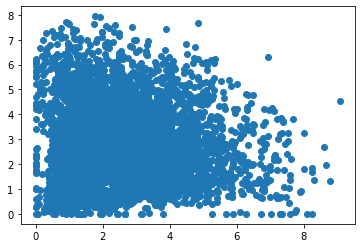

In [125]:
c = encoder_part.predict(train)
plt.scatter(c[:,0], c[:,1])

In [14]:
from Data.Data_Loader import Data_Loader
loader = Data_Loader(config)
train, test = loader.svdd_mnist()
#model.predict()

In [58]:
pre = svdd.predict(train)

In [23]:
value['c'][1]

1.4248506

In [39]:
normal_class = 1
abnormal_class = 3

batch_size = config['batch']
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784)) / 255.0
x_test = np.reshape(x_test, (-1, 784)) / 255.0

x_train_normal = x_train[np.where(y_train == normal_class)]
y_train_normal = y_train[np.where(y_train == normal_class)]

x_test_normal_index = (y_test == normal_class)
y_test_normal_index = (y_test == normal_class)
x_test_abnormal_index = (y_test == abnormal_class)
y_test_abnormal_index = (y_test == abnormal_class)

y_test[y_test_normal_index] = 0 #normal_class
y_test[y_test_abnormal_index] = 1 #abnormal_class

x_test = x_test[x_test_normal_index | x_test_abnormal_index]
y_test = y_test[y_test_normal_index | y_test_abnormal_index]


In [177]:
abnormal = x_test[np.where(y_test == 1)]
normal = x_test[np.where(y_test == 0)]

In [108]:
normal_image=ae.predict(normal)
abnormal_image = ae.predict(abnormal)

In [72]:
xx.shape

(1010, 28, 28)

In [98]:
a = encoder_part.predict(xx)
b = encoder_part.predict(yy)

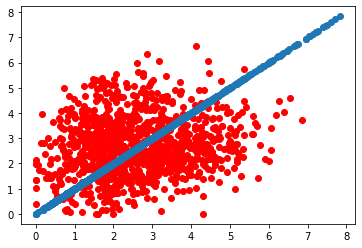

In [178]:
plt.scatter(a[:,0], a[:,1], color = 'r')
plt.scatter(b[:,1], b[:,1])

In [179]:
pre = svdd.predict(x_train_normal)
pre_a = svdd.predict(normal)
pre_b = svdd.predict(abnormal)

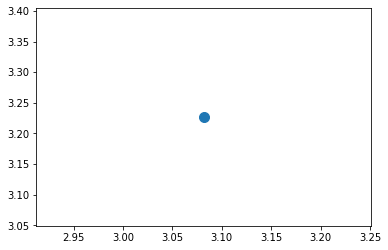

In [181]:
fig, ax = plt.subplots()
#ax.scatter(value['c'][:,0], value['c'][:,1])
#ax.scatter(pre[:,0], pre[:,1], color ='r')
#ax.scatter(pre_a[:,0], pre_a[:,1], color ='black')
#ax.scatter(pre_b[:,0], pre_b[:,1], color ='r')
ax.scatter(value['c'][0], value['c'][1], s = 100)

circle = plt.Circle((value['c'][0], value['c'][1]), value['R'], fill=False)
ax.add_artist(circle)
plt.show()

In [73]:
evaluation = Test(config, svdd, value)

Model.simple_model.DeepSVDD

In [90]:
x_test[x_test_normal_index].shape
#x_test[x_test_abnormal_index].shape
b = x_test[x_test_normal_index | x_test_abnormal_index].shape

In [93]:
y_test[y_test_normal_index] = 0

In [94]:
y_test[y_test_normal_index]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [46]:
a = svdd.predict(pretrain_train_dataset)
b = svdd.predict(pretrain_test_dataset)
c = svdd.predict(svdd_test_dataset)

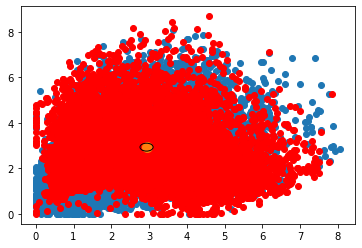

In [47]:
fig, ax = plt.subplots()
ax.scatter(c[:,0], c[:,1])
ax.scatter(a[:,0], a[:,1], color ='r')
ax.scatter(center[0], center[1], s = 100)

circle = plt.Circle((center[0], center[1]), R, fill=False)
ax.add_artist(circle)
plt.show()

In [ ]:
def gru_model(input_shape):
    """ Timeseries Forecasting을 위한 GRU 기반 Model
    
    Parameters
    ----------
    input_shape : tuple, Input Tensor Shape (timelength, features)
    
    Returns
    -------
    Tensorflow Model
    """
    
    n_sensors = input_shape[1]
    
    model_inputs = Input(shape=input_shape, name="Inputs")
    
    rnn = GRU(100, return_sequences=True)(model_inputs)
    rnn = GRU(100, return_sequences=True)(rnn)
    rnn = GRU(100, return_sequences=False)(rnn)
    dense = Dense(200, activation="relu")(rnn)
    dense = Dense(n_sensors)(dense)

    model_outputs = Reshape([1, -1])(dense)
    
    return Model(inputs=model_inputs, outputs=model_outputs)

In [ ]:
def model():
    